# MRI-7T-struct

**Overview**

This notebook will examine quantitative 7T MRI measures projected onto hippocampal surfaces and averaged across 10 subjects. Then we will combine this with 9.4T ex-vivo MRI data and examine conserved features using dimensionality reduction to see common patterns across all structural MRI maps.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import hippomaps as hm
import scipy
from hippomaps.build_mpc import build_mpc
from brainspace.gradient import GradientMaps

/export03/data/opt/venv/lib/python3.8/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [2]:
# config

useCheckpoints = True # this will download and use checkpoint numpy array data instead of mapping local data to hippocampal surfaces 
if useCheckpoints:
    hm.fetcher.get_tutorialCheckpoints(['MRI-7T-struct_unproc.npy'])
skipPreproc = True
if useCheckpoints:
    hm.fetcher.get_tutorialCheckpoints(['MRI-7T-struct_proc.npy'])
    
# locate input data
micapipe_dir = '/data/mica3/BIDS_PNI/derivatives/supersession'
hippunfold_dir = '/data/mica3/BIDS_PNI/derivatives/hippunfold_v1.3.0_supersession/hippunfold'
tmpdir = "tmp_7TsMRI"

# define which subjects and surfaces to examine
subs_7T = ['PNC002', 'PNC003', 'PNC006', 'PNC007', 'PNC009', 'PNC010', 'PNC015', 'PNC016', 'PNC018', 'PNC019']
ses = ''
hemis = ['L','R']
labels = ['hipp']#,'dentate'] 
den = '0p5mm'

# here we will generate multiple depth-wise surfaces
depths = np.linspace(-0.25,1.25,num=25) 
gm = np.where(np.logical_and(depths>=0,  depths <=1))[0]

# get expected number of vertices and their indices
nV,iV = hm.config.get_nVertices(labels,den) 

# loop through these types of structural images
features_7T = ['qT1','MTR','T2star','FA','ADC']

## 0) Map and load volumetric data to surfaces

As in all tutorials here, this step is OPTIONAL, and will be skipped by default. It provides an example of how data can be mapped to hippocampal surfaces outside of python (using `wb_command`). This relies on having the data stored locally, and should be considered example code. This code may differ depending on where/how your data is stored and formatted, and so may require some customization for new projects. For the purposes of this tutorial, we provide a matrix of loaded data at the end, so skip to the next step.

In this example, we loop through samples (that is, subjects and hemipsheres) and generate surfaces at different depths using the `wb_command` tool. Then, we loop through each modality and sample the data to those surfaces. Finally, we load the data from all surfaces into a single matrix.

In [3]:
if not useCheckpoints:

    # Note that all data is already aligned in space-T1w AKA space-nativepro!

    # intialize the matrix for loading data into
    hipp_dat_7T = np.zeros([nV,len(hemis),len(subs_7T),len(depths),len(features_7T)])*np.nan 
    !mkdir -p {tmpdir} # store intermediate files temporarily

    for s,sub in enumerate(subs_7T):
        for h,hemi in enumerate(hemis):
            for l,label in enumerate(labels):
                for d,depth in enumerate(depths):
                    
                    # create surface depths
                    cmd1 = f'wb_command -surface-cortex-layer '\
                        f'{hippunfold_dir}/sub-{sub}/surf/sub-{sub}_hemi-{hemi}_space-T1w_den-{den}_label-{label}_inner.surf.gii '\
                        f'{hippunfold_dir}/sub-{sub}/surf/sub-{sub}_hemi-{hemi}_space-T1w_den-{den}_label-{label}_outer.surf.gii '\
                        f'{depth} '\
                        f'tmp/sub-{sub}_hemi-{hemi}_label-{label}_layer-{depth}.surf.gii'
                    !{cmd1}
                    
                    # sample data to each surface
                    for f,feature in enumerate(features_7T):
                        cmd2 = f'wb_command -volume-to-surface-mapping '\
                            f'{micapipe_dir}/sub-{sub}/anat/sub-{sub}_space-nativepro_{feature}.nii.gz '\
                            f'tmp/sub-{sub}_hemi-{hemi}_label-{label}_layer-{depth}.surf.gii '\
                            f'tmp/sub-{sub}_hemi-{hemi}_label-{label}_layer-{depth}_{feature}.shape.gii '\
                            f'-trilinear'
                        !{cmd2}
                        
                        # now load the data!
                        surfdata = nib.load(f'tmp/sub-{sub}_hemi-{hemi}_label-{label}_layer-{depth}_{feature}.shape.gii')
                        hipp_dat_7T[iV[l],h,s,d,f] = surfdata.darrays[0].data
                        
        print(f'sub-{sub} done')

    np.save("checkpoints/MRI-7T-struct_unproc",hipp_dat_7T, allow_pickle=True)
    !rm -rf {tmpdir}

## 1) Load and plot all surface data

Here, we use the data already loaded into a large matrix from step 0). This matrix `hipp_dat_7T` has a shape of (number of vertices nV) x (number of hemsipheres 2) x (number of subjects) x (number of surface depths) x (number of features or image types)

In [4]:
if not skipPreproc:

    # Load data
    hipp_dat_7T = np.load("checkpoints/MRI-7T-struct_unproc.npy")

    # Preprocess
    # Profile align the depths of each column (as in https://github.com/jordandekraker/hippomaps/blob/master/tutorials/Histology-MRI-9p4T.ipynb)
    for f,feature in enumerate(features_7T):
        for s,sub in enumerate(subs_7T):
            for h,hemi in enumerate(hemis):  
                hipp_dat_7T[:,h,s,:,f] = hm.utils.profile_align(hipp_dat_7T[:,h,s,:,f])

    # that step can be quite slow, so we'll save a checkpoint so we can more easily resume from there without having to redo everything
    np.save("checkpoints/MRI-7T-struct_proc",hipp_dat_7T, allow_pickle=True)

Now lets use our plotting tools to make a nice plot, averaging across depths and hemispheres and subjects

/export03/data/opt/BrainSpace/brainspace/plotting/base.py:287: UserWarning: Interactive mode requires 'panel'. Setting 'interactive=False'
  warnings.warn("Interactive mode requires 'panel'. "


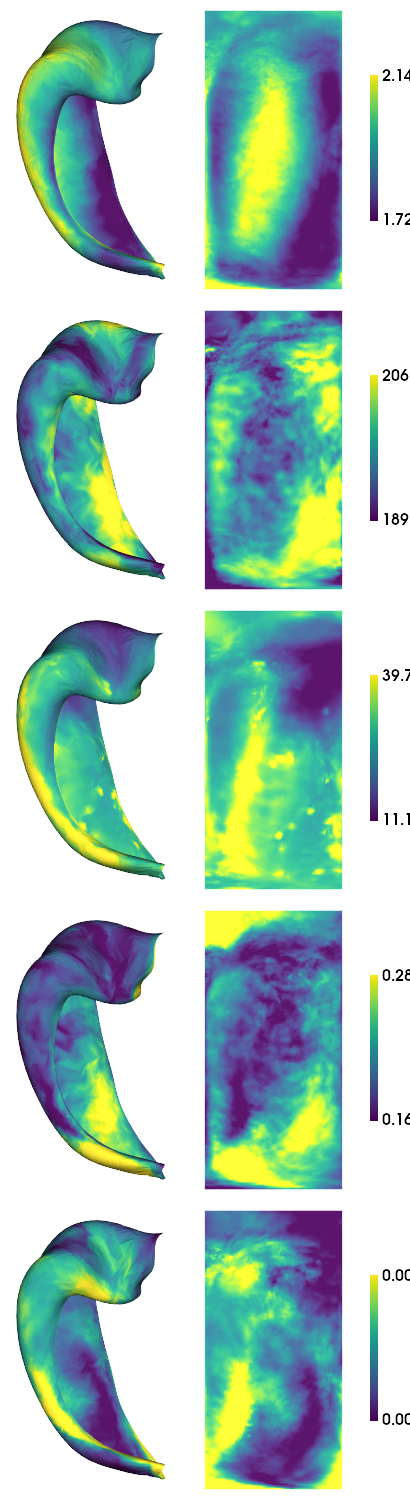

In [5]:
hipp_dat_7T = np.load("checkpoints/MRI-7T-struct_proc.npy")

cdata = hipp_dat_7T[:,:,:,gm,:] # trim the data that is not actually inside our grey matter bound
cdata = np.nanmean(cdata,axis=(1,2,3)) # average over subjects, hemispheres, and depths for visualization
hm.plotting.surfplot_canonical_foldunfold(cdata, color_bar=('right'), hemis=['L'], labels=['hipp'], unfoldAPrescale=True, share='row', tighten_cwindow=True, embed_nb=True)

## 2) Stability between subjects

To make sure our measures are consistent, we will check whether they are correlated across samples (that is, across subjects and hemipsheres)

In [6]:
# again average across depths for a given feature (feature 0 )
cdata = np.nanmean(hipp_dat_7T[:,:,:,gm,0],axis=3)
# reshape so subject hemispheres are listed in the same dimension
cdata = cdata.reshape((7262,-1))
cdata.shape

(7262, 20)

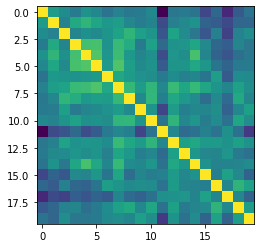

In [7]:
# now we can see the vertex-wise correlation between all 20 subject hemispheres
plt.imshow(np.corrcoef(cdata.T))

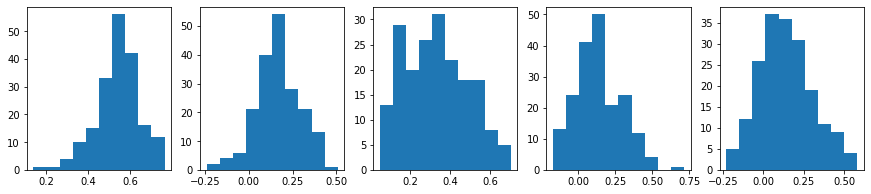

In [8]:
# now repeat for all features and make a histogram of the off-diagonal values
mfcorr = []
sdfcorr = []
fig, ax = plt.subplots(nrows=1, ncols=len(features_7T), figsize=(3*len(features_7T),3))
for f,feature in enumerate(features_7T):
    cdat = np.nanmean(hipp_dat_7T[:,:,:,gm,f],axis=3).reshape((7262,-1)) # as above
    corr = np.corrcoef(cdat.T) # as above 2
    fcorr = corr[np.triu_indices(20,k=1)] # this return only the off-diagonal (lower left triangle)
    ax[f].hist(fcorr) # make a histogram for this particular feature
    mfcorr.append(np.mean(fcorr))
    sdfcorr.append(np.std(fcorr))

These are some nice correlations; consistently above zero!

**Add another dataset (9.4T data)**

In this case, data was samples on a denser surface (`den='unfoldiso'`). Thus we will have to interpolate it to the `den='0p5mm'` surfaces that we've been using so far

In [9]:
# add in 9.4T data that we already preprocessed in Histology-MRI-9p4T.ipynb

features_9p4T = ['PD', 'R1', 'R2star']
subs_9p4T = ['122017', '152017']

tmp = np.load("checkpoints/struct-HISTO-proc.npy")[:,:,-4*3:] # only the last set of 12 maps are from 9.4T MRI; the others are from histology and so we will discard them

# downsample to 0p5mm and format as above
hipp_dat_9p4T = np.zeros([nV,len(hemis),len(subs_9p4T),len(depths),len(features_9p4T)])*np.nan 
# resample
for d,depth in enumerate(depths):
    n=0
    for f,featue in enumerate(features_9p4T):
        for s,sub in enumerate(subs_9p4T):
            for h,hemi in enumerate(hemis):
                hipp_dat_9p4T[:,h,s,d,f],_,_ = hm.utils.density_interp('unfoldiso','0p5mm',tmp[:,d,n],'hipp')
                n=n+1

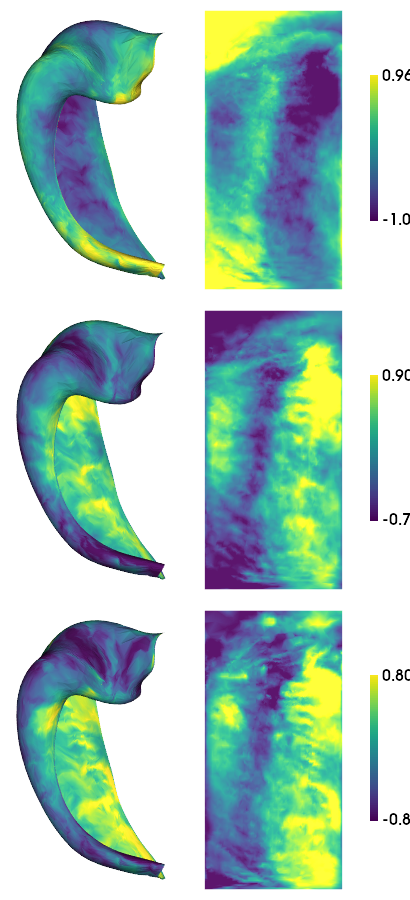

In [10]:
cdata = hipp_dat_9p4T[:,:,:,gm,:] # trim the data that is not actually inside our grey matter bound
cdata = np.nanmean(cdata,axis=(1,2,3)) # average over subjects, hemispheres, and depths for visualization
hm.plotting.surfplot_canonical_foldunfold(cdata, color_bar=('right'), hemis=['L'], labels=['hipp'], unfoldAPrescale=True, share='row', tighten_cwindow=True, embed_nb=True)

As above, we will check whether measures are correlated across samples (that is, across subjects and hemipsheres)

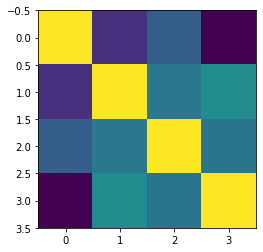

In [11]:
plt.imshow(np.corrcoef(np.nanmean(hipp_dat_9p4T[:,:,:,gm,f],axis=3).reshape((7262,-1)).T))

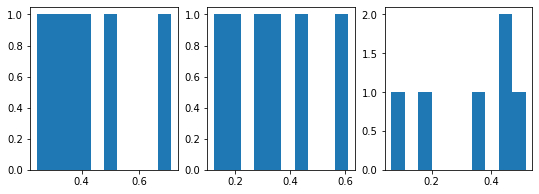

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=len(features_9p4T), figsize=(3*len(features_9p4T),3))
for f,feature in enumerate(features_9p4T):
    cdat = np.nanmean(hipp_dat_9p4T[:,:,:,gm,f],axis=3).reshape((7262,-1))
    corr = np.corrcoef(cdat.T)
    fcorr = corr[np.triu_indices(4,k=1)]
    ax[f].hist(fcorr)
    mfcorr.append(np.mean(fcorr))
    sdfcorr.append(np.std(fcorr))

Not as nice looking as before, since we only have 4 samples to look at. But still correlations are well above zero!

**Make a summary plot of consistency**

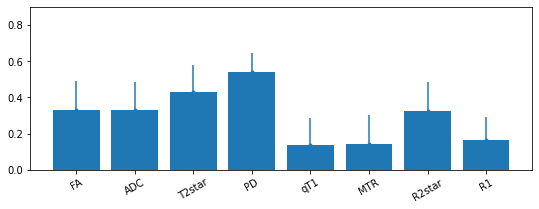

In [13]:
# combine the two datasets
xnames = features_9p4T + features_7T
# reorder to match what's written in the manuscript
myorder=[6,7,5,0,3,4,2,1]
xnames = [xnames[i] for i in myorder]
mfcorr = [mfcorr[i] for i in myorder]
sdfcorr = [sdfcorr[i] for i in myorder]

# instead of histograms, we will show a bar plot of the average and standard deviation
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3*len(features_9p4T),3))
plt.bar(range(8),mfcorr)
plt.errorbar(range(8),mfcorr, yerr=sdfcorr, fmt=".")
plt.xticks(ticks=range(8),labels=xnames,rotation=30)
plt.ylim([0,.9]);

## 3) Summarize data according to primary gradients

Dimensionality reduction allows us to summarize many maps as primary components, or Gradients. Here we will use BrainSpace to compute nonlinear Gradients using diffusion map embedding. Briefly, this typically consists of computing an affinity matrix (e.g. a correlation between all maps) and then grouping them into a few consistent patterns (Gradients). In this case, we will consider not only the correlation between maps, but also across depths. All depths from a given vertex are sometimes called microstructural profiles (MPs), and the similarity between all profiles is thus a microstructural profile covariance (MPC) matrix. In this case we also consider multiple modalities, making a multimodal MPC (mMPC). 

In [14]:
# as before, we will average across subjects and hemispheres, giving us a total of 8 features that are group-averaged maps. This time we don't average depths though.

modality_data = np.concatenate((np.nanmean(hipp_dat_9p4T,axis=(1,2)),np.nanmean(hipp_dat_7T,axis=(1,2))),axis=2)
modality_data.shape

(7262, 25, 8)

In [15]:
mMP = np.reshape(modality_data[:,gm,:],(nV,-1)).T #flatten. Each vertex now has a vector of depths for all modalities.
mMPC, I, problemNodes = build_mpc(np.concatenate((mMP,np.mean(mMP,axis=0).reshape((1,-1))))) # compute mMPC

/export03/data/opt/hippomaps/hippomaps/build_mpc.py:145: RuntimeWarning: divide by zero encountered in true_divide
  MPC = 0.5 * np.log( np.divide(1 + R, 1 - R) )


(-0.5, 7261.5, 7261.5, -0.5)

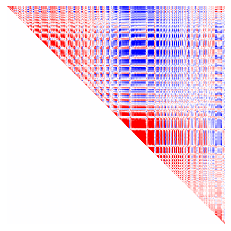

In [16]:
# plot the mMPC to get a sense of similarity between vertices.
plt.imshow(mMPC, vmin=-1, vmax=1, cmap='bwr')
plt.axis('off')

In [26]:
# multimodal gradient map (mGM) decomposition using default parameters 
nGrads = 3
mGM = GradientMaps()
mGM.fit(mMPC)

/export03/data/opt/BrainSpace/brainspace/gradient/embedding.py:70: UserWarning: Affinity is not symmetric. Making symmetric.
  warnings.warn('Affinity is not symmetric. Making symmetric.')


GradientMaps()

/export03/data/opt/BrainSpace/brainspace/plotting/base.py:287: UserWarning: Interactive mode requires 'panel'. Setting 'interactive=False'
  warnings.warn("Interactive mode requires 'panel'. "


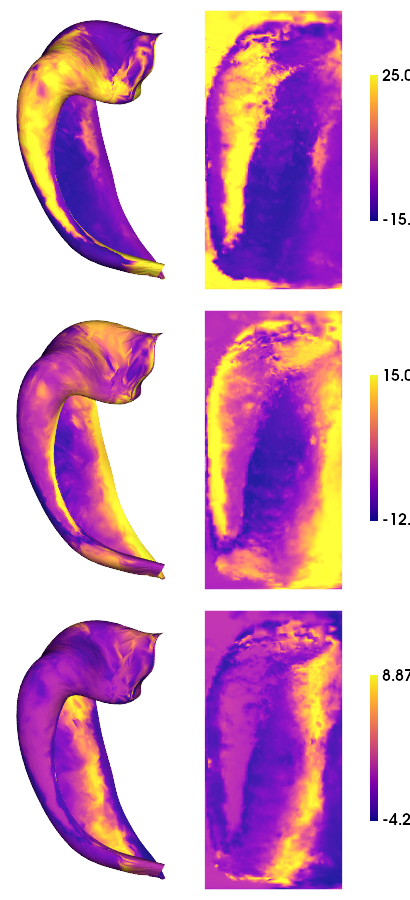

In [27]:
# As above, we can make a nice plot for each of the resulting gradients
hm.plotting.surfplot_canonical_foldunfold(mGM.gradients_[:,:nGrads], labels=['hipp'], hemis=['L'], unfoldAPrescale=True, den='0p5mm', cmap='plasma', color_bar='right', share='row',  tighten_cwindow=False, embed_nb=True)

[0.42233552 0.2354442  0.08587242 0.05986693 0.05011692 0.03994275
 0.03121151 0.02930138 0.02342769 0.0224807 ]


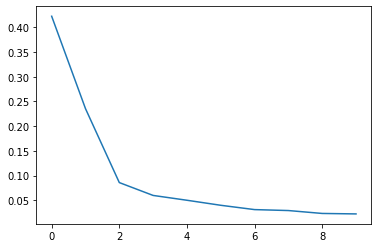

In [19]:
# we can also see the lambda value (or eigenvalue) for each gradient
plt.plot(mGM.lambdas_/np.sum(mGM.lambdas_))
print(mGM.lambdas_/np.sum(mGM.lambdas_))

**save**

In [20]:
# save 2D maps (7T)
!mkdir -p ../maps/HippoMaps-initializationMaps/Dataset-PNI
for f,feature in enumerate(features_7T):
    cdat = np.nanmean(hipp_dat_7T[:,:,:,gm,f],axis=(1,2,3)).flatten()
    data_array = nib.gifti.GiftiDataArray(data=cdat)
    image = nib.gifti.GiftiImage()
    image.add_gifti_data_array(data_array)
    nib.save(image, f'../maps/HippoMaps-initializationMaps/Dataset-PNI/MRI-7T-{feature}_average-20_hemi-mix_den-0p5mm_label-hipp.shape.gii')

In [21]:
# save 2D maps (9.4T)
!mkdir -p ../maps/HippoMaps-initializationMaps/Dataset-AHEAD
for f,feature in enumerate(features_9p4T):
    cdat = np.nanmean(hipp_dat_9p4T[:,:,:,gm,f],axis=(1,2,3)).flatten()
    data_array = nib.gifti.GiftiDataArray(data=cdat)
    image = nib.gifti.GiftiImage()
    image.add_gifti_data_array(data_array)
    nib.save(image, f'../maps/HippoMaps-initializationMaps/Dataset-AHEAD/MRI-9p4T-{feature}_average-4_hemi-mix_den-0p5mm_label-hipp.shape.gii')